In [2]:
import numpy as np
import pandas as pd
import datetime
import time
from scipy.stats import itemfreq

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import preprocessing 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# Load data

In [3]:
#Define testfile
test_file = 'Dataset/INDEX/ICEX Main (OMXIPI).xlsx'

# Create dataframe
df = pd.read_excel(test_file)

# PreProcessing

In [4]:
# Convert timestamp to datetime
df['Date'] = pd.to_datetime(df['Date']).apply(lambda x: x.date())
df = df.sort('Date', ascending=True)

# Create returns
df['Return'] = df['Price'].pct_change(periods=1)
df['Return_shift'] = df.Return.shift(1)
df['Price_shift'] = df.Price.shift(1)
df['Return3'] = df['Price_shift'].pct_change(periods=3)
df['Return5'] = df['Price_shift'].pct_change(periods=5)
df['Return10'] = df['Price_shift'].pct_change(periods=10)
df['Return20'] = df['Price_shift'].pct_change(periods=20)
df['Return50'] = df['Price_shift'].pct_change(periods=50)

# Create moving price averages
df['3DaySMA'] = df['Price_shift'].rolling(center=False,window =3).mean()
df['5DaySMA'] = df['Price_shift'].rolling(center=False,window =5).mean()
df['10DaySMA'] = df['Price_shift'].rolling(center=False,window=10).mean()
df['20DaySMA'] = df['Price_shift'].rolling(center=False,window=20).mean()
df['50DaySMA'] = df['Price_shift'].rolling(center=False,window=50).mean()

# Exponential Weighted Moving Average
df['EWMA'] = df.Price_shift.ewm(com=0.5,min_periods=0,adjust=True,ignore_na=False).mean()

# Drop NAN
# TODO: Find better approach
df = df.dropna()

C:\Users\petur\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


# ML - PreProcessing

In [5]:
df_new = df.copy()

# Create labels [0: "Down", 1: "Up"]
le = preprocessing.LabelEncoder()
df_new['UpDown'] = np.where(df_new['Return']>=0, 'Up', 'Down')
df_new.UpDown = le.fit(df_new.UpDown).transform(df_new.UpDown)


# Define training features and label
features = df_new.columns[10:-1]
X = preprocessing.scale(df_new[features])    
y = df_new.UpDown   

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(len(X), "Total datapoints")
print(len(X_train), "Training datapoints")
print(len(X_test), " Testing datapoints")
print(len(df_new[features].columns), "Features")
print(itemfreq(df_new.UpDown))


1807 Total datapoints
1355 Training datapoints
452  Testing datapoints
11 Features
[[  0 854]
 [  1 953]]


In [6]:
# Print out evaluation metrics
def print_evaluation(true_label, prediction):
    accuracy = accuracy_score(y_test, prediction)
    metrics = precision_recall_fscore_support(y_test, prediction, average='binary')

    print("Accuracy:  ", accuracy)
    print("Precision: ", metrics[0])
    print("Recall:    ", metrics[1])
    print("F1-score:  ", metrics[2])

# Ensemble classifier

In [7]:
time_Start =time.time()

# Classifier
clf = ExtraTreesClassifier(n_estimators=1000)
clf = clf.fit(X_train, y_train)

# Prediction
prediction = clf.predict(X_test)
print_evaluation(y_test, prediction)

time_End = time.time()
print("Seconds to run:", time_End-time_Start )

Accuracy:   0.513274336283
Precision:  0.533864541833
Recall:     0.565400843882
F1-score:   0.549180327869
Seconds to run: 2.665999412536621


# Linear SVM Classifier

In [8]:
# Start timer
time_Start =time.time()

# Classifier
clf = LinearSVC()
clf.fit(X_train, y_train)

# Prediction
prediction = clf.predict(X_test)
print_evaluation(y_test, prediction)

# End timer and results
time_End = time.time()
print("Seconds to run:", time_End-time_Start )

Accuracy:   0.53982300885
Precision:  0.534117647059
Recall:     0.957805907173
F1-score:   0.68580060423
Seconds to run: 0.16829919815063477


In [8]:
print(itemfreq(prediction))
print(prediction)

[[  0  27]
 [  1 425]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1]


In [9]:
# Start timer
time_Start =time.time()

# Classifier
clf = SVC()
clf.fit(X_train, y_train)

# Prediction
prediction = clf.predict(X_test)
print_evaluation(y_test, prediction)

# End timer and results
time_End = time.time()
print("Seconds to run:", time_End-time_Start )

Accuracy:   0.526548672566
Precision:  0.529411764706
Recall:     0.873417721519
F1-score:   0.65923566879
Seconds to run: 0.09875726699829102


In [10]:
print(itemfreq(prediction))
print(prediction)

[[  0  61]
 [  1 391]]
[1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1
 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1
 1 1 1 1 1 1 1 1]


# Feature importance

C:\Users\petur\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


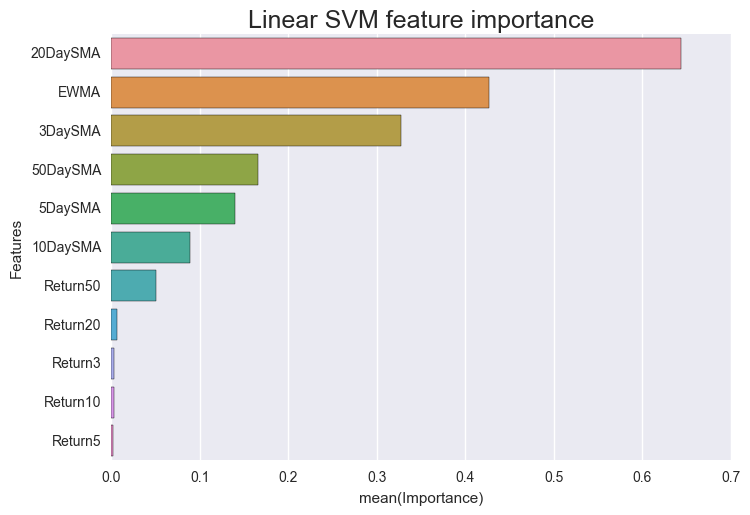

In [11]:
# Define features and importance
df_feature = pd.DataFrame()
df_feature['Features'] = df_new[features].columns
weights = clf.coef_ * clf.coef_
weights = abs(clf.coef_)
df_feature['Importance'] = weights[0]
df_feature.sort(['Importance'],ascending=False)
top5 = df_feature.Features[0:5]

# Plot feature importance
sns.barplot(y = 'Features', x = 'Importance', data=df_feature.sort_values(by='Importance', ascending=False))
plt.title("Linear SVM feature importance", fontsize=18)
plt.show()

In [15]:
weights = clf.coef_ * clf.coef_
print(weights)
print(df_feature['Features'])


[[  9.59734189e-06   4.14610228e-06   8.86933763e-06   4.79619834e-05
    2.52231931e-03   1.06891728e-01   1.94842527e-02   8.02912860e-03
    4.14368260e-01   2.74313007e-02   1.82209710e-01]]
0      Return3
1      Return5
2     Return10
3     Return20
4     Return50
5      3DaySMA
6      5DaySMA
7     10DaySMA
8     20DaySMA
9     50DaySMA
10        EWMA
Name: Features, dtype: object


In [16]:
df.head()

,Date,Price,Open,High,Low,Volume,Change%,Return,Return_shift,Price_shift,...,Return5,Return10,Return20,Return50,3DaySMA,5DaySMA,10DaySMA,20DaySMA,50DaySMA,EWMA
1806,2010-03-16,549.73,552.10,552.10,547.85,-,-0.0045,-0.004509,0.010504,552.22,...,0.018048,0.030031,0.091797,0.117764,549.323333,546.134,539.411,527.3435,512.6452,550.369914
1805,2010-03-17,556.05,549.74,556.62,549.74,-,0.0115,0.011497,-0.004509,549.73,...,0.022316,0.032783,0.087519,0.111756,549.476667,548.534,541.156,529.5555,513.7504,549.943305
1804,2010-03-18,564.50,555.62,567.77,555.62,-,0.0152,0.015196,0.011497,556.05,...,0.020331,0.048577,0.093424,0.117015,552.666667,550.750,543.732,531.9310,514.9154,554.014435
1803,2010-03-19,565.85,564.52,572.02,564.52,-,0.0024,0.002391,0.015196,564.50,...,0.027728,0.067935,0.110128,0.133443,556.760000,553.796,547.323,534.7310,516.2446,561.004812
1802,2010-03-22,569.67,566.22,569.67,566.14,-,0.0068,0.006751,0.002391,565.85,...,0.035445,0.067944,0.120029,0.125017,562.133333,557.670,550.923,537.7630,517.5022,564.234937


In [36]:
df.Price
df.Date
ts = pd.Series(df.Price.values, index = df.Date)

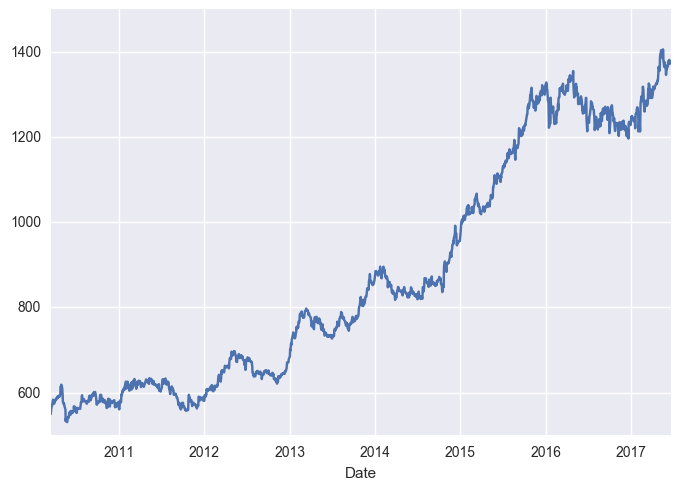

In [37]:
ts.plot()
plt.show()